# **Imports**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import entropy
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, precision_score, recall_score, auc, confusion_matrix, roc_curve, RocCurveDisplay

# **Data exploration and visualization**

In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
train_data.head()

,flow_time,header_size,packet_duration,overall_rate,src_rate,dst_rate,fin_packets,urg_packets,rst_packets,max_value,...,syn_flags,rst_flags,psh_flags,ack_flags,protocol_http,protocol_https,protocol_tcp,protocol_udp,protocol_icmp,label
0,0.041268,15499.00,64.00,7805.845961,7805.845961,0.0,0.0,0.00,0.00,50.00,...,0,0,0,0,0,0,0,1,0,DDoS
1,0.018393,3702.54,64.00,6728.994198,6728.994198,0.0,0.0,0.00,0.01,54.28,...,0,0,0,0,0,0,0,1,0,DDoS
2,0.000000,182.00,64.00,38.559448,38.559448,0.0,0.0,0.00,0.00,182.00,...,0,0,0,0,0,0,0,1,0,DoS
3,0.109292,35027.55,62.72,6783.234241,6783.234241,0.0,0.0,0.03,0.11,65.11,...,0,0,0,0,0,0,0,1,0,DoS
4,0.000000,162.00,64.00,2.305494,2.305494,0.0,0.0,0.00,0.00,162.00,...,0,0,0,0,0,0,0,1,0,DoS


In [ ]:
train_data.duplicated().sum()

np.int64(96187)

In [ ]:
train_data.drop_duplicates(inplace=True)

In [ ]:
train_data.isna().sum()

flow_time           0
header_size         0
packet_duration     0
overall_rate        0
src_rate            0
dst_rate            0
fin_packets         0
urg_packets         0
rst_packets         0
max_value           0
value_covariance    0
fin_flags           0
syn_flags           0
rst_flags           0
psh_flags           0
ack_flags           0
protocol_http       0
protocol_https      0
protocol_tcp        0
protocol_udp        0
protocol_icmp       0
label               0
dtype: int64

In [ ]:
train_data['label'].unique()

array(['DDoS', 'DoS', 'BenignTraffic', 'Mirai', 'Recon', 'MITM'],
      dtype=object)

In [ ]:
train_data['label'].unique()

array(['DDoS', 'DoS', 'BenignTraffic', 'Mirai', 'Recon', 'MITM'],
      dtype=object)

In [ ]:
# abs(correlation_matrix["label"]).sort_values(ascending=False)

In [ ]:
train_data.drop(columns=["overall_rate"], inplace=True)
test_data.drop(columns=["overall_rate"], inplace=True)
test_data.drop(columns=["Id"], inplace=True)

In [ ]:
train_data.columns

Index(['flow_time', 'header_size', 'packet_duration', 'src_rate', 'dst_rate',
       'fin_packets', 'urg_packets', 'rst_packets', 'max_value',
       'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags',
       'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp',
       'protocol_udp', 'protocol_icmp', 'label'],
      dtype='object')

In [ ]:
test_data.columns

Index(['flow_time', 'header_size', 'packet_duration', 'src_rate', 'dst_rate',
       'fin_packets', 'urg_packets', 'rst_packets', 'max_value',
       'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags',
       'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp',
       'protocol_udp', 'protocol_icmp'],
      dtype='object')

# **Data Features**

In [ ]:
train_data["rate_ratio"] = train_data["src_rate"] / (train_data["dst_rate"] + 1e-5)
train_data["rate_sum"] = train_data["src_rate"] + train_data["dst_rate"]

train_data["flow_time_per_byte"] = train_data["flow_time"] / (train_data["header_size"] + 1)
train_data["duration_per_rate"] = train_data["packet_duration"] / (train_data["src_rate"] + 1)

flag_cols = ["ack_flags", "fin_flags", "syn_flags", "psh_flags", "rst_flags"]
train_data["total_flags"] = train_data[flag_cols].sum(axis=1)
train_data["is_flag_heavy"] = (train_data["total_flags"] > 2).astype(int)

train_data["is_tcp_heavy"] = train_data["protocol_tcp"] * train_data["src_rate"]
train_data["is_udp_slow"] = train_data["protocol_udp"] * train_data["packet_duration"]

train_data["rate_diff"] = abs(train_data["src_rate"] - train_data["dst_rate"])
train_data["flow_per_header"] = train_data["flow_time"] / (train_data["header_size"] + 1)

train_data["is_short_packet"] = (train_data["packet_duration"] < 10).astype(int)
train_data["is_one_way"] = ((train_data["src_rate"] > 0) & (train_data["dst_rate"] == 0)).astype(int)



test_data["rate_ratio"] = test_data["src_rate"] / (test_data["dst_rate"] + 1e-5)
test_data["rate_sum"] = test_data["src_rate"] + test_data["dst_rate"]

test_data["flow_time_per_byte"] = test_data["flow_time"] / (test_data["header_size"] + 1)
test_data["duration_per_rate"] = test_data["packet_duration"] / (test_data["src_rate"] + 1)

flag_cols = ["ack_flags", "fin_flags", "syn_flags", "psh_flags", "rst_flags"]
test_data["total_flags"] = test_data[flag_cols].sum(axis=1)
test_data["is_flag_heavy"] = (test_data["total_flags"] > 2).astype(int)

test_data["is_tcp_heavy"] = test_data["protocol_tcp"] * test_data["src_rate"]
test_data["is_udp_slow"] = test_data["protocol_udp"] * test_data["packet_duration"]

test_data["rate_diff"] = abs(test_data["src_rate"] - test_data["dst_rate"])
test_data["flow_per_header"] = test_data["flow_time"] / (test_data["header_size"] + 1)

test_data["is_short_packet"] = (test_data["packet_duration"] < 10).astype(int)
test_data["is_one_way"] = ((test_data["src_rate"] > 0) & (test_data["dst_rate"] == 0)).astype(int)

In [ ]:
test_data["header_size"] = np.log1p(test_data["header_size"])
test_data["flow_time"] = np.log1p(test_data["flow_time"])
test_data["src_rate"] = np.log1p(test_data["src_rate"])
test_data["value_covariance"] = np.log1p(test_data["value_covariance"])
test_data["max_value"] = np.log1p(test_data["max_value"])
test_data["packet_duration"] = np.log1p(test_data["packet_duration"])
test_data["urg_packets"] = np.log1p(test_data["urg_packets"])
test_data["rst_packets"] = np.log1p(test_data["rst_packets"])
test_data["rate_diff"]=np.log1p(test_data["rate_diff"])
test_data["rate_ratio"]=np.log1p(test_data["rate_ratio"])
test_data["rate_sum"]=np.log1p(test_data["rate_sum"])
test_data["flow_time_per_byte"]=np.log1p(test_data["flow_time_per_byte"])
test_data["duration_per_rate"]=np.log1p(test_data["duration_per_rate"])
test_data["is_tcp_heavy"]=np.log1p(test_data["is_tcp_heavy"])
test_data["is_udp_slow"]=np.log1p(test_data["is_udp_slow"])
test_data["flow_per_header"]=np.log1p(test_data["flow_per_header"])


train_data["header_size"] = np.log1p(train_data["header_size"])
train_data["flow_time"] = np.log1p(train_data["flow_time"])
train_data["src_rate"] = np.log1p(train_data["src_rate"])
train_data["value_covariance"] = np.log1p(train_data["value_covariance"])
train_data["max_value"] = np.log1p(train_data["max_value"])
train_data["packet_duration"] = np.log1p(train_data["packet_duration"])
train_data["urg_packets"] = np.log1p(train_data["urg_packets"])
train_data["rst_packets"] = np.log1p(train_data["rst_packets"])
train_data["rate_diff"]=np.log1p(train_data["rate_diff"])
train_data["rate_ratio"]=np.log1p(train_data["rate_ratio"])
train_data["rate_sum"]=np.log1p(train_data["rate_sum"])
train_data["flow_time_per_byte"]=np.log1p(train_data["flow_time_per_byte"])
train_data["duration_per_rate"]=np.log1p(train_data["duration_per_rate"])
train_data["is_tcp_heavy"]=np.log1p(train_data["is_tcp_heavy"])
train_data["is_udp_slow"]=np.log1p(train_data["is_udp_slow"])
train_data["flow_per_header"]=np.log1p(train_data["flow_per_header"])

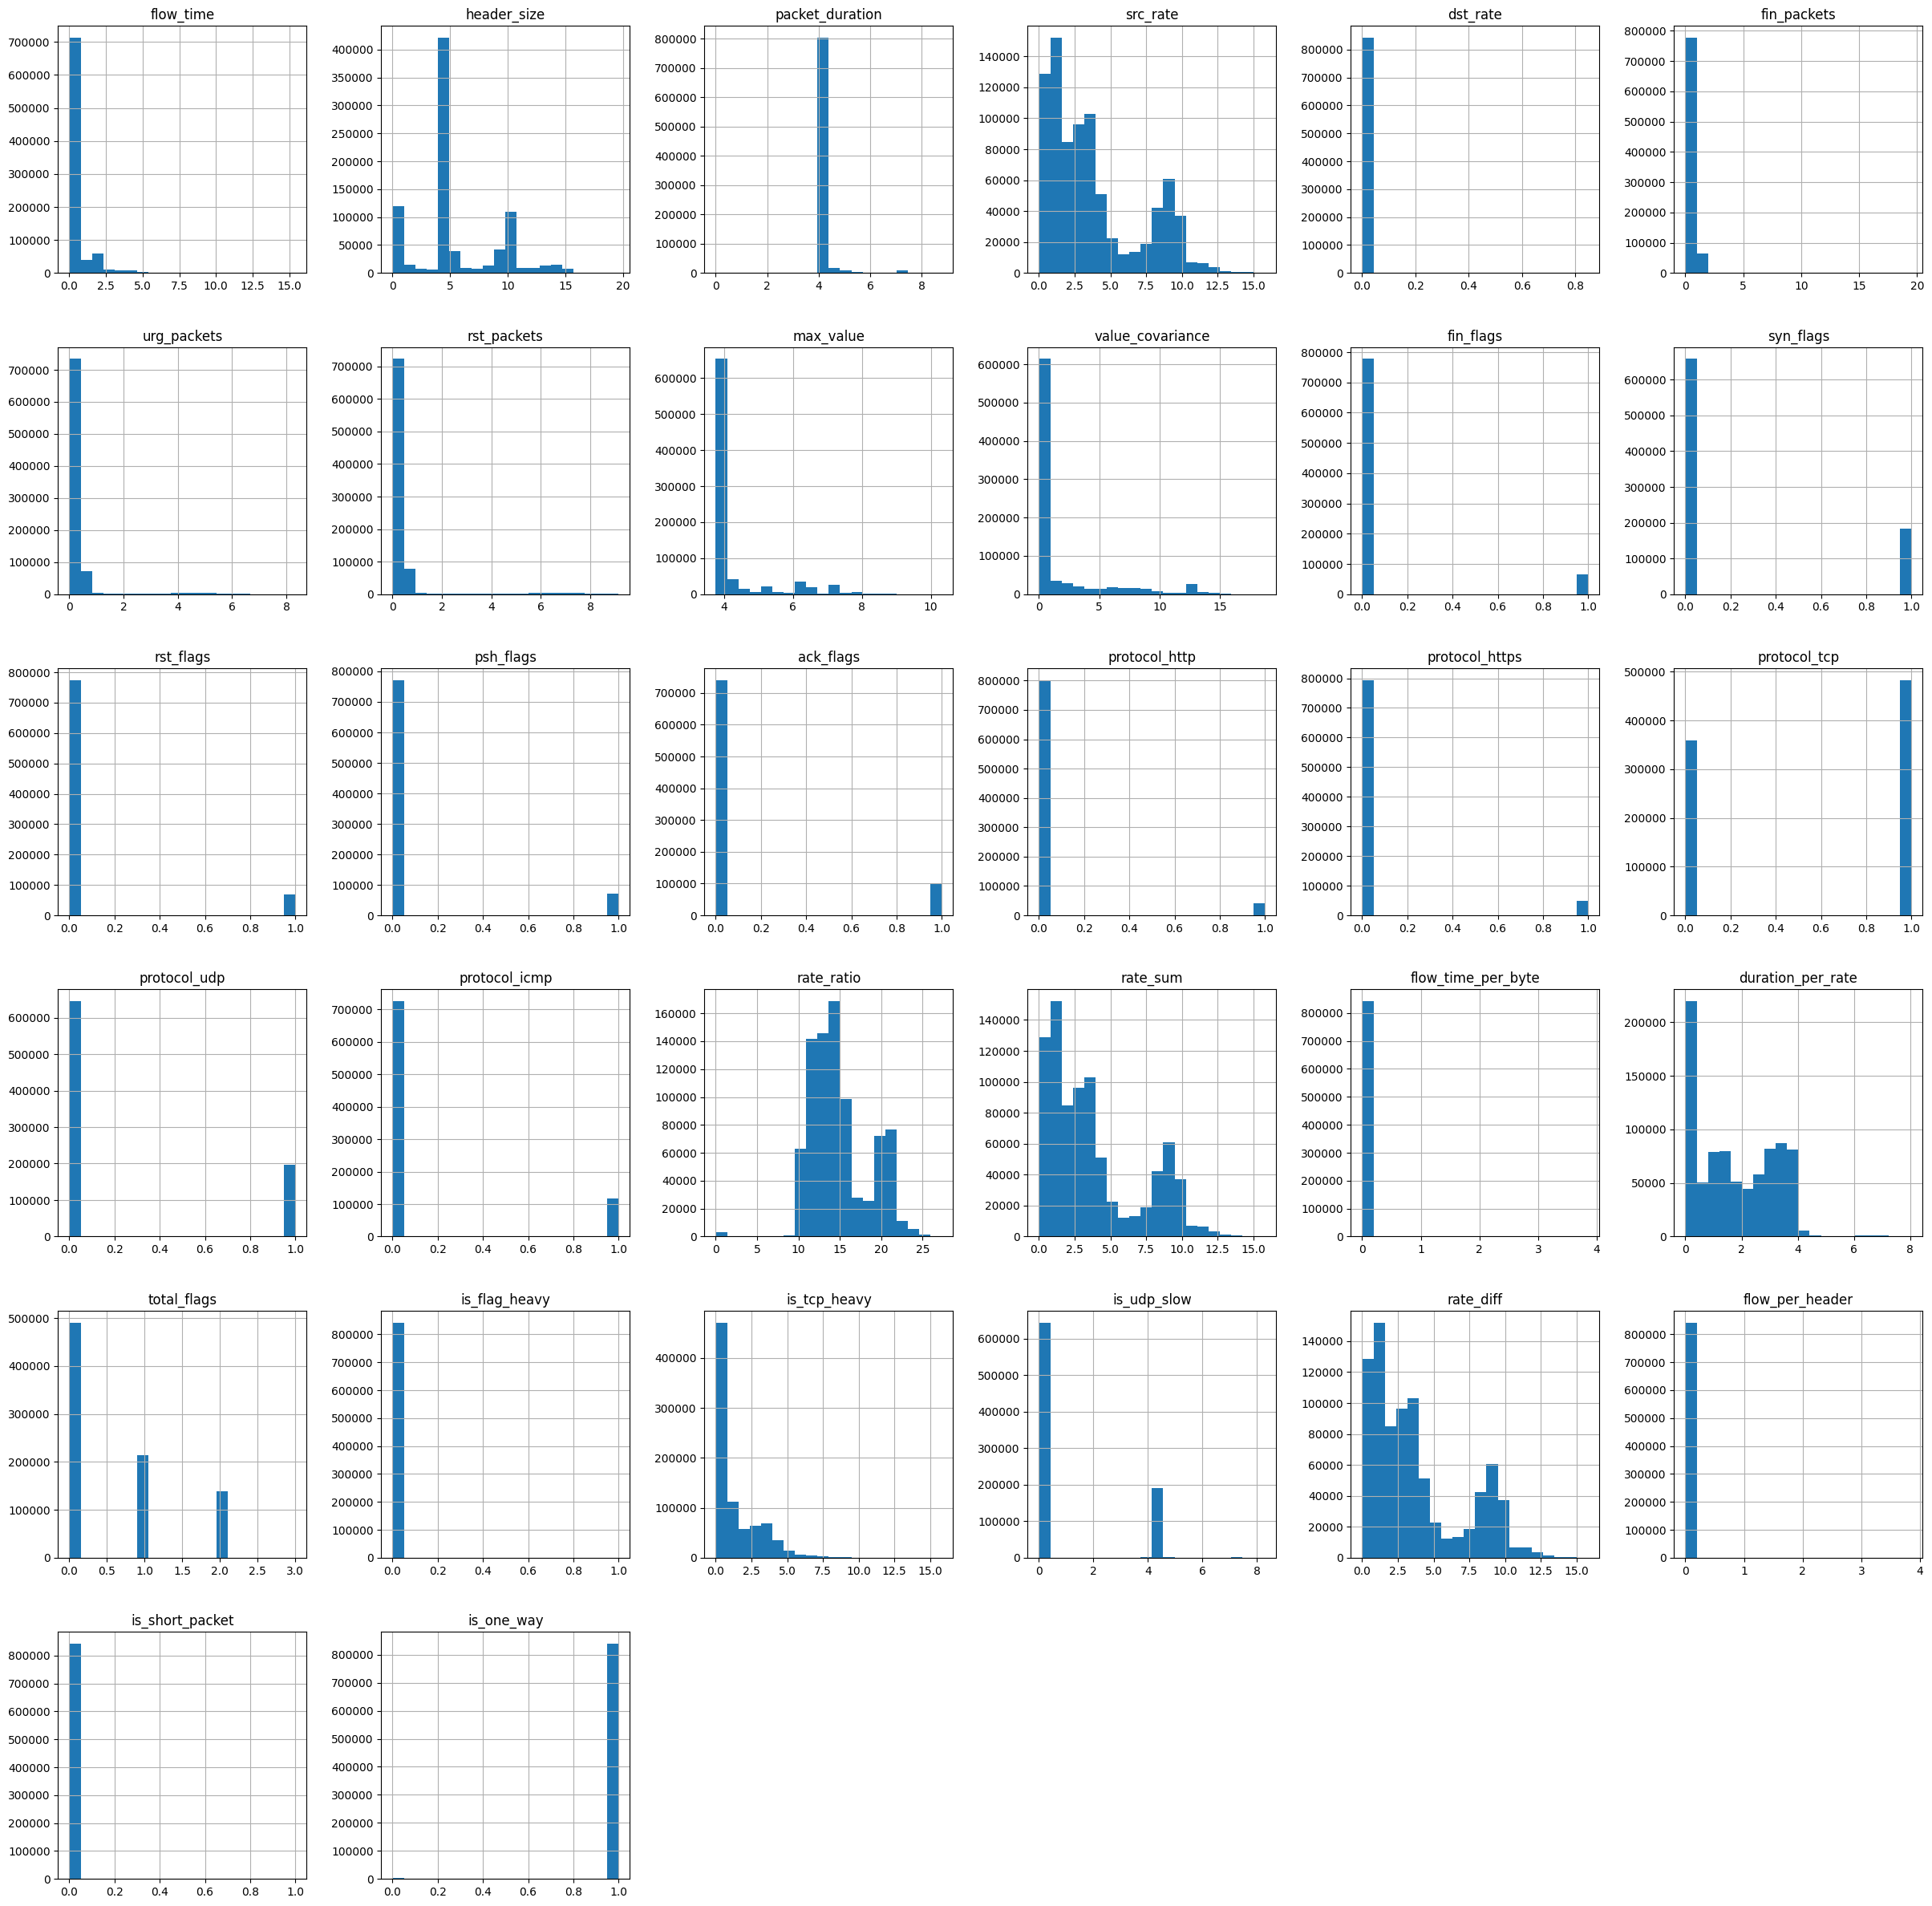

In [ ]:
train_data.hist(bins=20, figsize=(30,30))
plt.show()

# **Data preprocessing**

In [ ]:
train_data.shape

(842396, 33)

In [ ]:
le = LabelEncoder()
train_data["label"] = le.fit_transform(train_data["label"])

In [ ]:
x = train_data.drop(["label"], axis=1)
y = train_data["label"]

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(x, y, random_state=42, test_size = 0.2)

In [ ]:
x_train.shape

(673916, 32)

In [ ]:
x_test.shape

(168480, 32)

In [ ]:
x_train.head()

,flow_time,header_size,packet_duration,src_rate,dst_rate,fin_packets,urg_packets,rst_packets,max_value,value_covariance,...,flow_time_per_byte,duration_per_rate,total_flags,is_flag_heavy,is_tcp_heavy,is_udp_slow,rate_diff,flow_per_header,is_short_packet,is_one_way
780814,1.659196,5.093750,4.174387,0.533715,0.0,0.0,0.000000,0.00000,4.007333,0.000000,...,0.025770,3.651464,1,0,0.533715,0.0,0.533715,0.025770,0,1
806559,0.006614,6.624729,4.164492,1.611770,0.0,0.0,0.019803,0.41211,7.300338,12.650637,...,0.000009,2.613189,0,0,0.000000,0.0,1.611770,0.000009,0,1
344210,0.000000,1.913977,4.203348,2.724140,0.0,0.0,0.000000,0.00000,6.381071,7.188976,...,0.000000,1.672200,0,0,0.000000,0.0,2.724140,0.000000,0,1
722506,0.000000,0.000000,4.174387,4.092891,0.0,0.0,0.000000,0.00000,3.761200,0.000000,...,0.000000,0.726688,0,0,0.000000,0.0,4.092891,0.000000,0,1
480992,0.000000,4.007333,4.174387,1.179605,0.0,0.0,0.000000,0.00000,4.007333,0.000000,...,0.000000,3.028858,1,0,1.179605,0.0,1.179605,0.000000,0,1


In [ ]:
test_data.shape

(104287, 32)

In [ ]:
test_data.columns

Index(['flow_time', 'header_size', 'packet_duration', 'src_rate', 'dst_rate',
       'fin_packets', 'urg_packets', 'rst_packets', 'max_value',
       'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags',
       'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp',
       'protocol_udp', 'protocol_icmp', 'rate_ratio', 'rate_sum',
       'flow_time_per_byte', 'duration_per_rate', 'total_flags',
       'is_flag_heavy', 'is_tcp_heavy', 'is_udp_slow', 'rate_diff',
       'flow_per_header', 'is_short_packet', 'is_one_way'],
      dtype='object')

In [ ]:
x_train.columns

Index(['flow_time', 'header_size', 'packet_duration', 'src_rate', 'dst_rate',
       'fin_packets', 'urg_packets', 'rst_packets', 'max_value',
       'value_covariance', 'fin_flags', 'syn_flags', 'rst_flags', 'psh_flags',
       'ack_flags', 'protocol_http', 'protocol_https', 'protocol_tcp',
       'protocol_udp', 'protocol_icmp', 'rate_ratio', 'rate_sum',
       'flow_time_per_byte', 'duration_per_rate', 'total_flags',
       'is_flag_heavy', 'is_tcp_heavy', 'is_udp_slow', 'rate_diff',
       'flow_per_header', 'is_short_packet', 'is_one_way'],
      dtype='object')

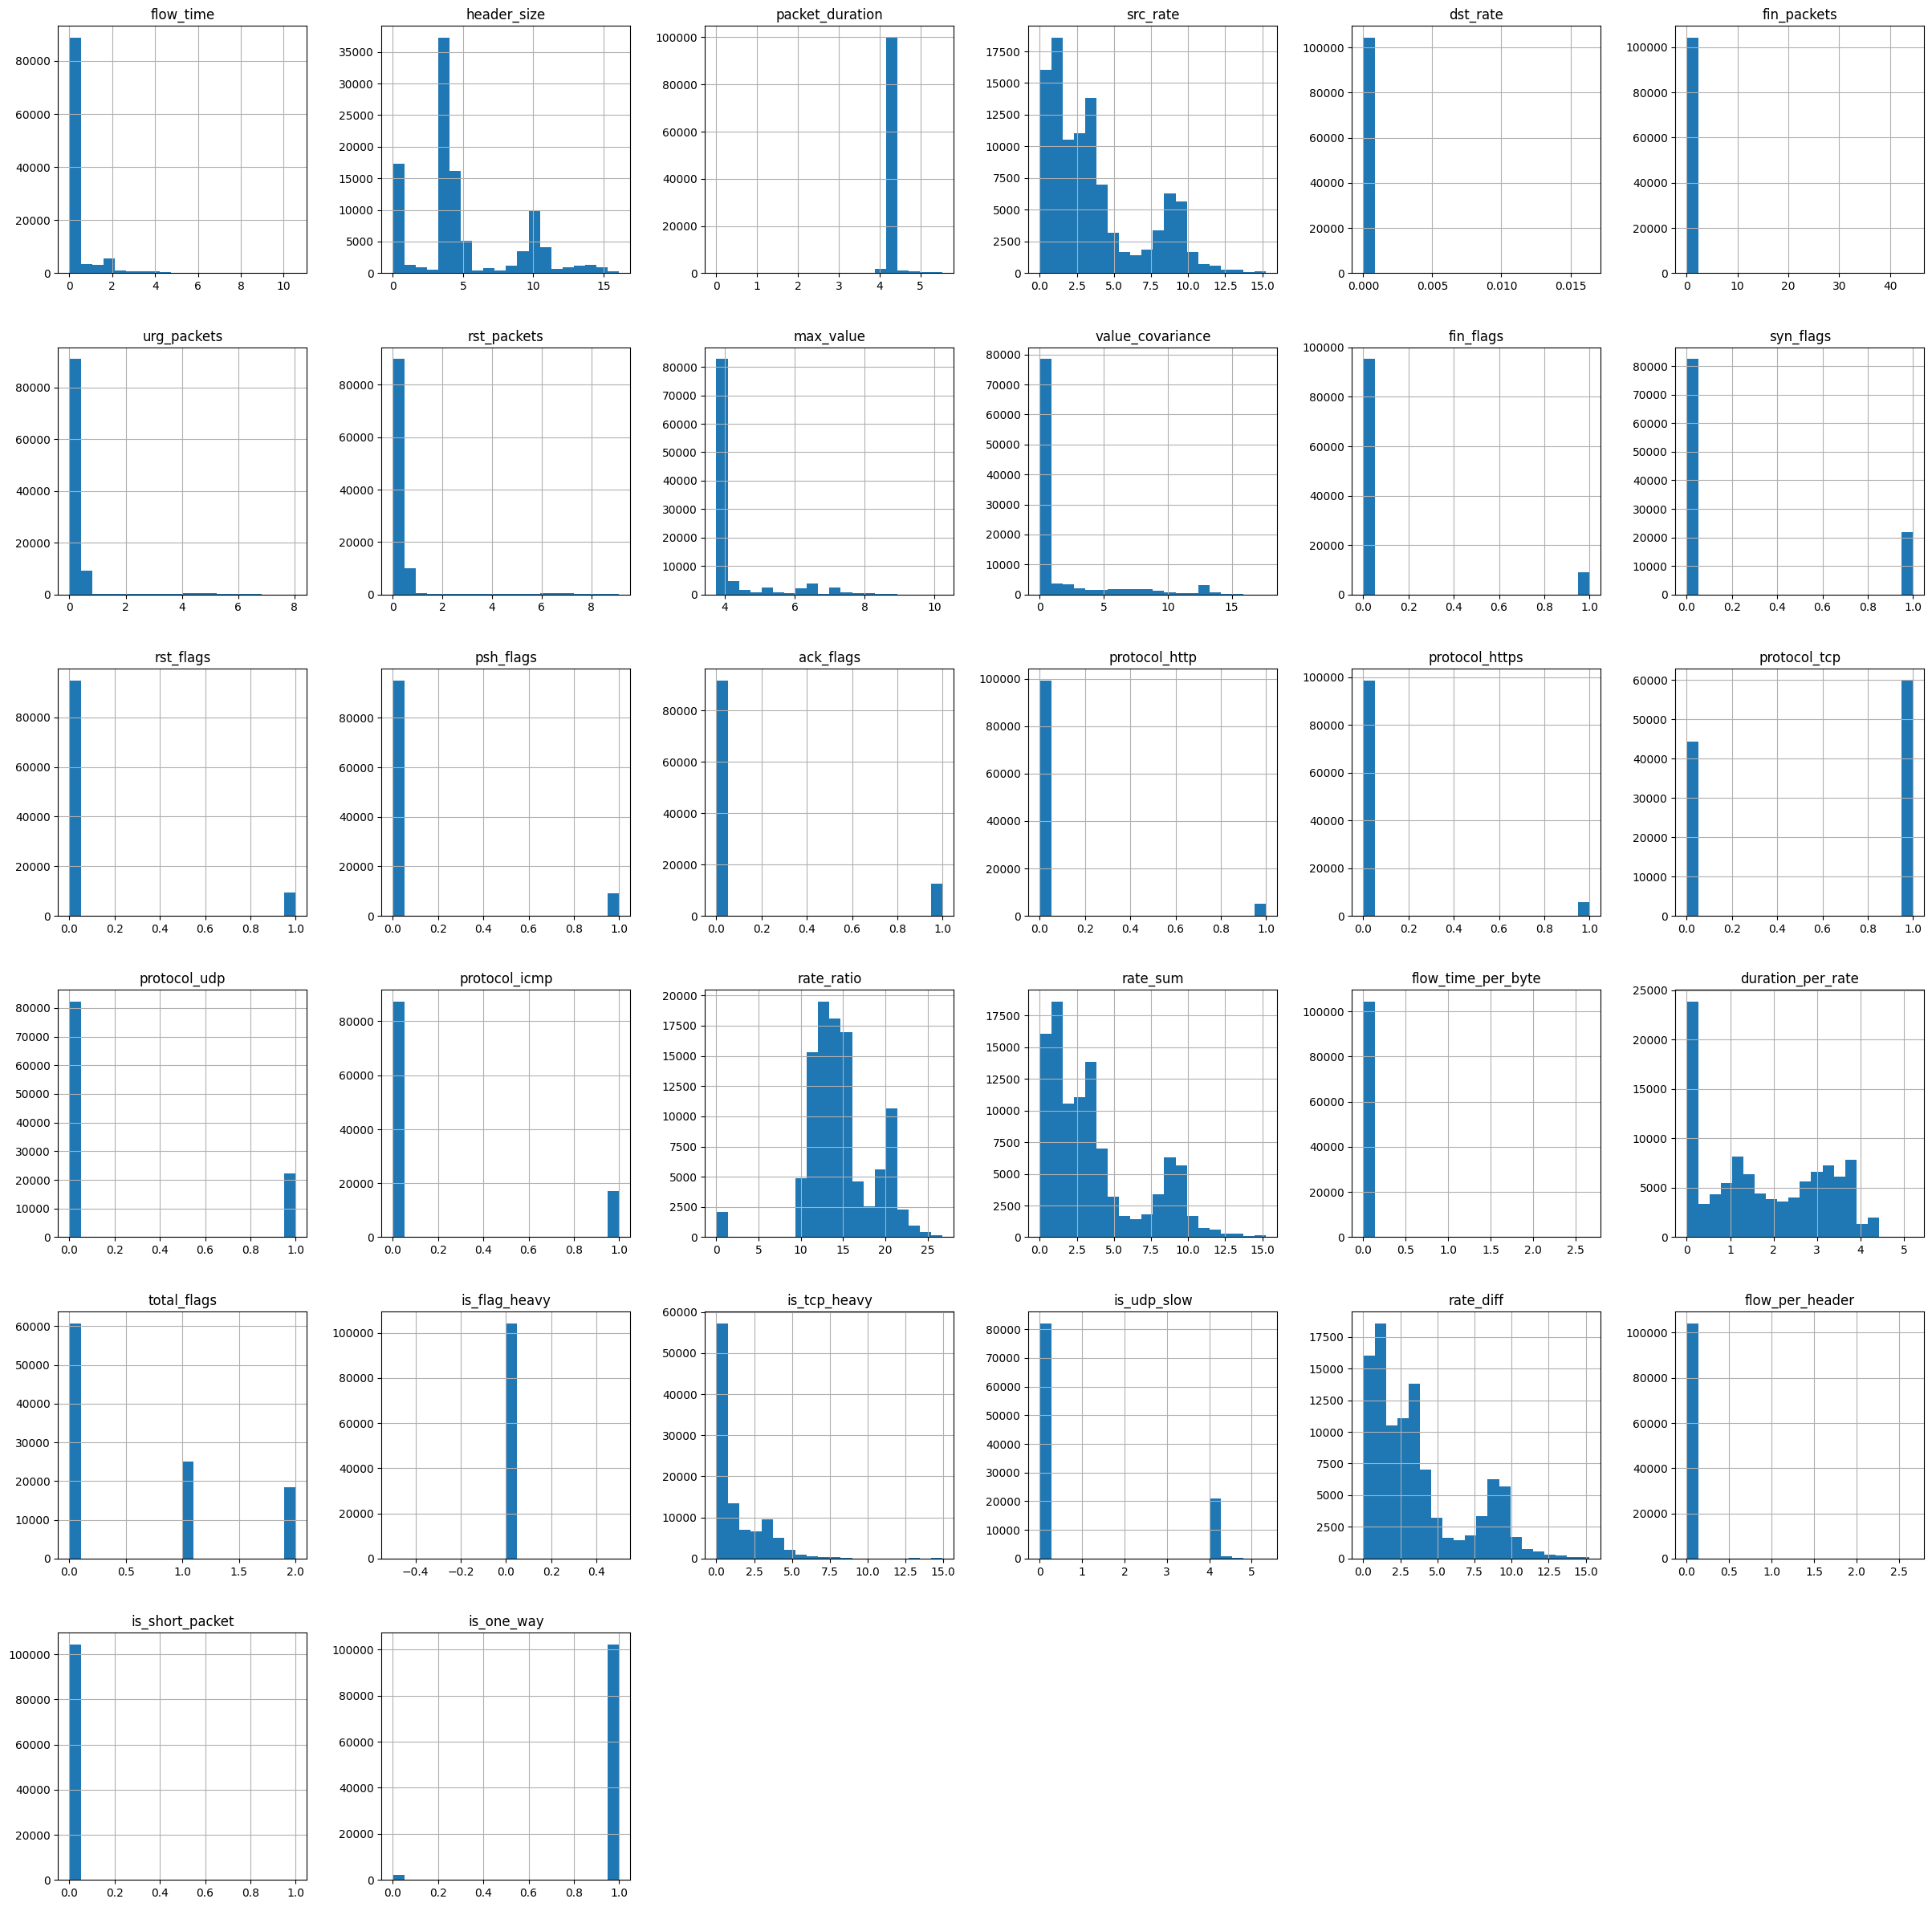

In [ ]:
test_data.hist(bins=20, figsize=(30,30))
plt.show()

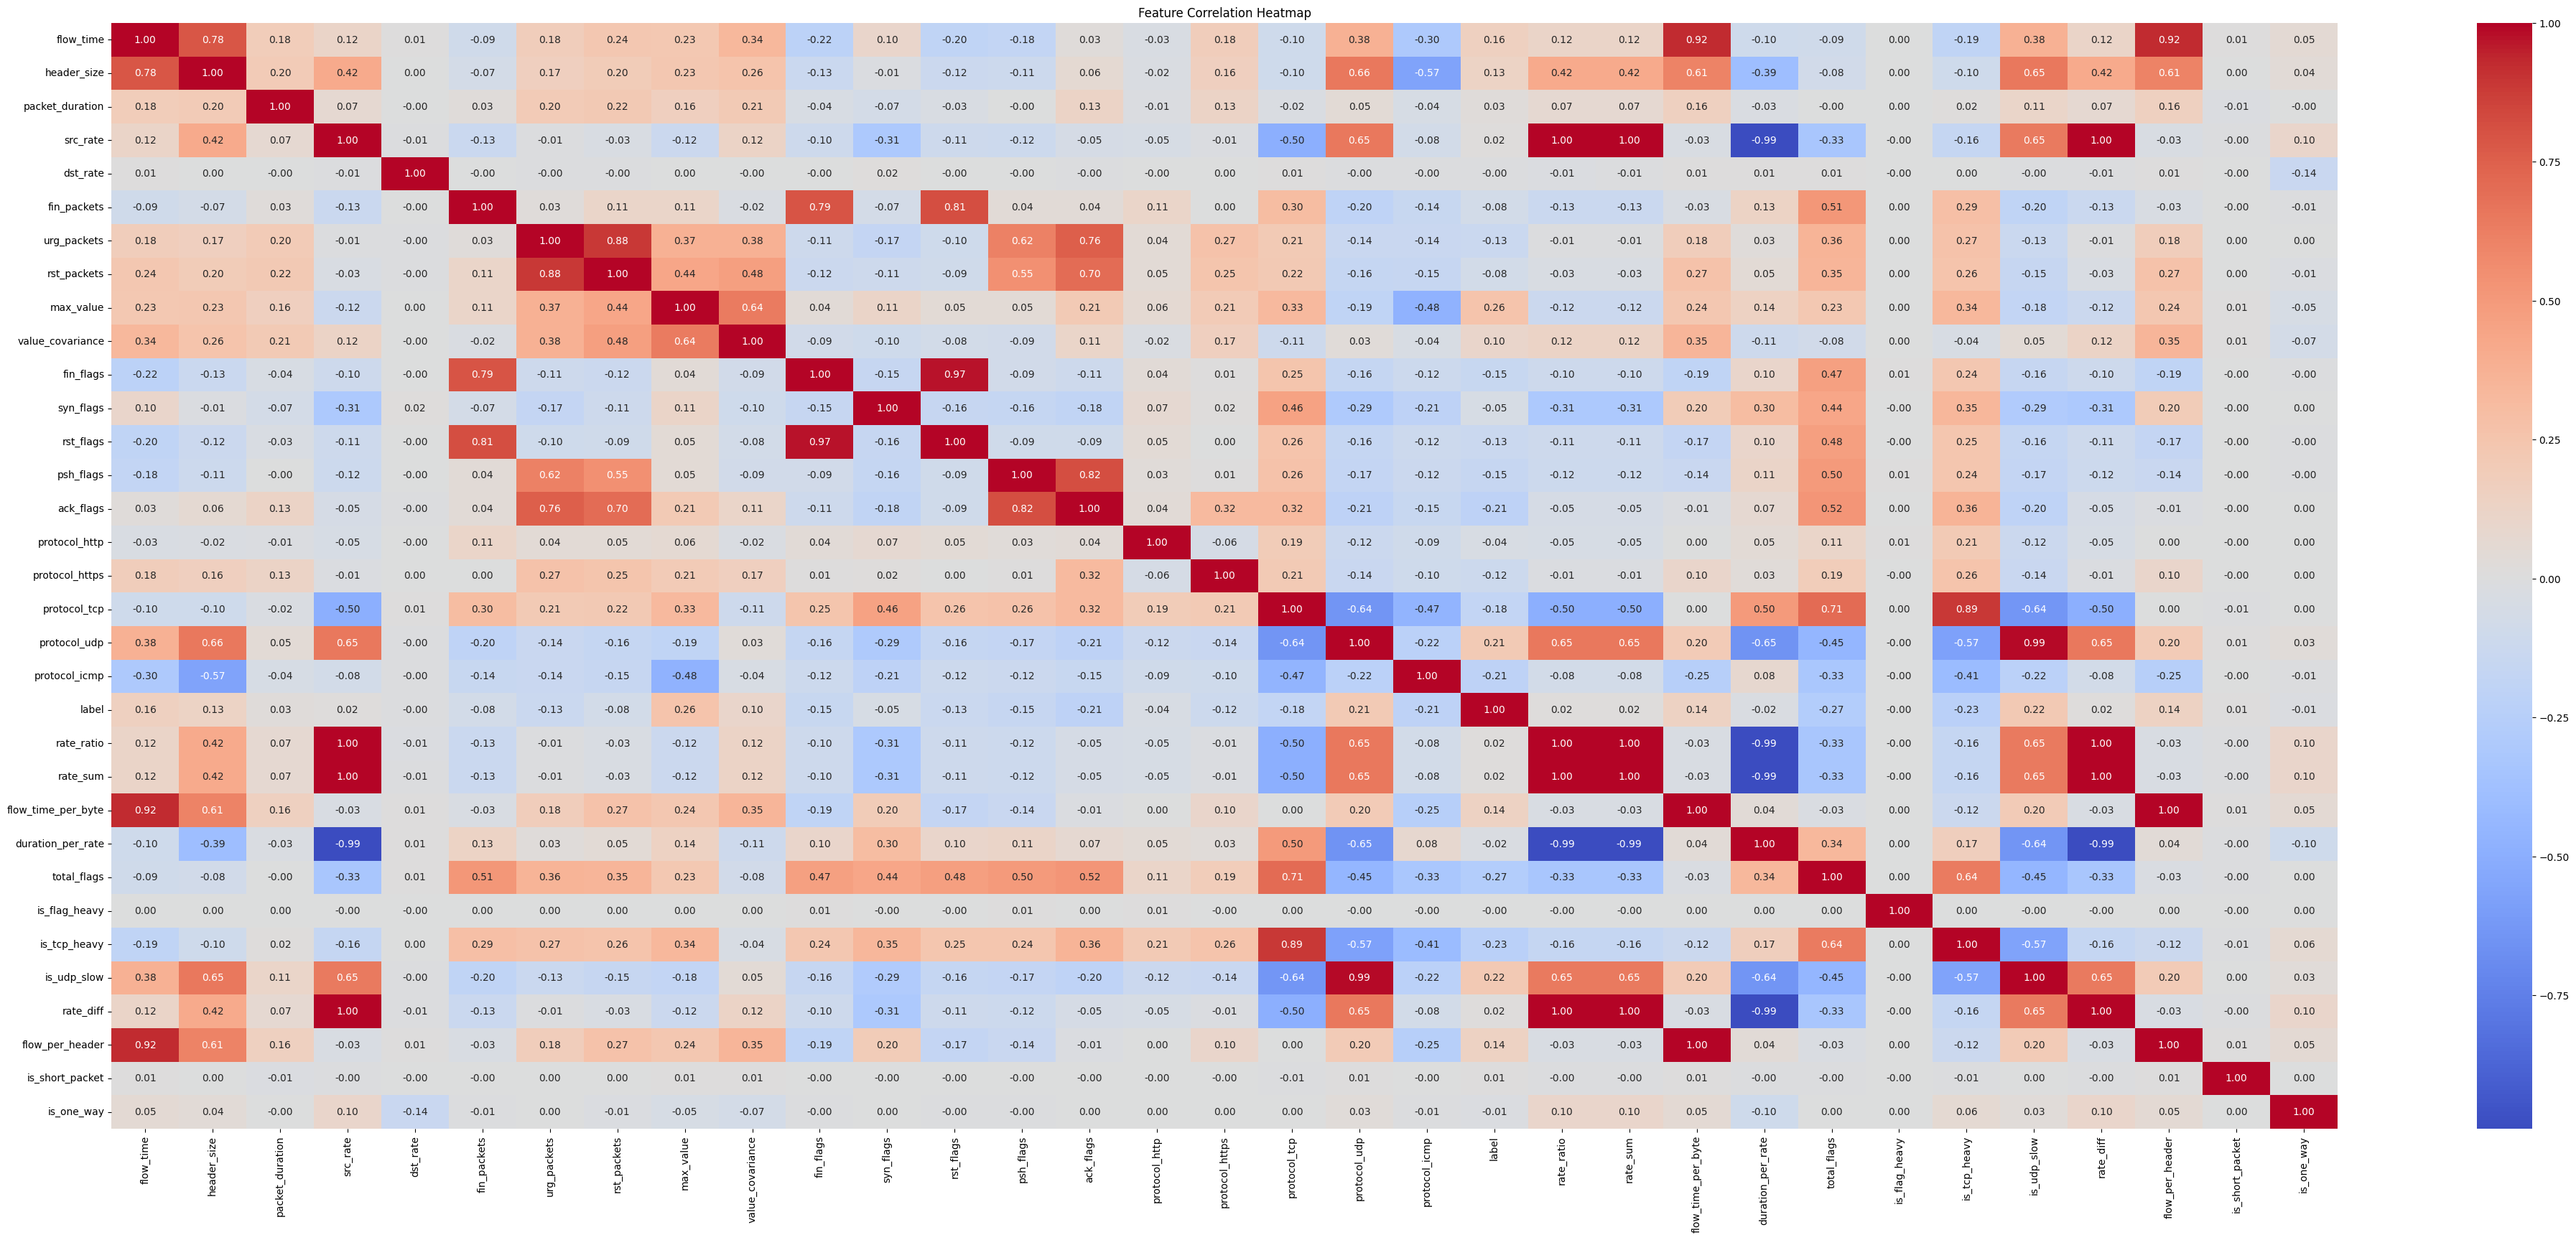

In [ ]:
categorical_columns = train_data.select_dtypes(include=["object"]).columns.tolist()

correlation_matrix = train_data.corr(method="spearman")

plt.figure(figsize=(50, 20))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# **Logistic regression**

In [ ]:
lg = LogisticRegression(penalty='l2',
C=0.5,
solver='liblinear',
class_weight='balanced'
)
lg.fit(x_train, y_train)

y_pred = lg.predict(test_data)

# **Decision tree**

In [ ]:
decision_tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    criterion='gini'
)
decision_tree.fit(x_train, y_train)

y_pred = decision_tree.predict(test_data)

# **Random forest**

In [ ]:
random_forest= RandomForestClassifier(
            n_estimators=200,
            max_depth=30,
            n_jobs=-1,
            random_state=42
        )

In [ ]:
random_forest.fit(x_train, y_train)
y_pred_rf = random_forest.predict(x_test)

In [ ]:
print("Accuracy of the random forest is ", accuracy_score(y_test, y_pred_rf))

In [ ]:
random_forest.fit(x_train, y_train)
y_pred_rf = random_forest.predict(test_data)

In [ ]:
print(y_pred_rf)

In [ ]:
output_df = pd.DataFrame()
pred_rf_values = []
ids  = []
for i in range(len(y_pred_rf)):
    ids.append(i)
    if y_pred_rf[i] == 1:
        pred_rf_values.append("DDoS")
    if y_pred_rf[i]==2:
        pred_rf_values.append("DoS")
    if y_pred_rf[i]==0:
        pred_rf_values.append("BenignTraffic")
    if y_pred_rf[i]==4:
        pred_rf_values.append("Mirai")
    if y_pred_rf[i]==5:
        pred_rf_values.append("Recon")
    if y_pred_rf[i]==3:
        pred_rf_values.append("MITM")

output_df["Id"] = ids
output_df["Target"] = pred_rf_values
output_df = output_df[["Id", "Target"]]
output_df.to_csv("random forest.csv", index=False)

# **LGBM**

In [ ]:
lgbm_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=15,
    num_leaves=128,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=60,
    reg_alpha=0.1,
    reg_lambda=0.1,
    objective='multiclass',
    num_class=6,
    random_state=42,
    verbose=-1
)

In [ ]:
lgbm_model.fit(x_train, y_train)
lgbm_preds = lgbm_model.predict(x_test)

In [ ]:
print("Accuracy of lgbm: ", accuracy_score(y_test, lgbm_preds))

In [ ]:
lgbm_model.fit(x_train, y_train)
lgbm_preds = lgbm_model.predict(test_data)

In [ ]:
print(lgbm_preds)

In [ ]:
output_df = pd.DataFrame()
pred_values = []
ids  = []
for i in range(len(lgbm_preds)):
    ids.append(i)
    if lgbm_preds[i] == 1:
        pred_values.append("DDoS")
    if lgbm_preds[i]==2:
        pred_values.append("DoS")
    if lgbm_preds[i]==0:
        pred_values.append("BenignTraffic")
    if lgbm_preds[i]==4:
        pred_values.append("Mirai")
    if lgbm_preds[i]==5:
        pred_values.append("Recon")
    if lgbm_preds[i]==3:
        pred_values.append("MITM")

output_df["Id"] = ids
output_df["Target"] = pred_values
output_df = output_df[["Id", "Target"]]
output_df.to_csv("lgbm.csv", index=False)

# **Neural network**

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(
    hidden_layer_sizes=(128, 264, 128),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

model.fit(x_train, y_train)

y_pred = model.predict(test_data)

# **XGBoost**

In [ ]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.5,
    reg_lambda=1.0,
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42
)
xgb.fit(x_train, y_train)

y_pred = xgb.predict(test_data)

# **Catboost model**

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=1000,
                            depth=15,
                            learning_rate=0.02,
                            loss_function='MultiClass',
                            verbose=False,
                            task_type='GPU',
                            eval_metric='TotalF1',
                            early_stopping_rounds=60,
                            random_seed=42
)



In [ ]:
model.fit(x_train, y_train)
cat_pred = model.predict(x_test)

KeyboardInterrupt: 

In [ ]:
print("CatBoost Classifier Accuracy: ", accuracy_score(y_test, cat_pred))

In [ ]:
model.fit(x_train, y_train)
cat_pred = model.predict(test_data)

In [ ]:
print(cat_pred)

In [ ]:
output_df = pd.DataFrame()
pred_values = []
ids  = []
for i in range(len(cat_pred)):
    ids.append(i)
    if cat_pred[i] == 1:
        pred_values.append("DDoS")
    if cat_pred[i]==2:
        pred_values.append("DoS")
    if cat_pred[i]==0:
        pred_values.append("BenignTraffic")
    if cat_pred[i]==4:
        pred_values.append("Mirai")
    if cat_pred[i]==5:
        pred_values.append("Recon")
    if cat_pred[i]==3:
        pred_values.append("MITM")

output_df["Id"] = ids
output_df["Target"] = pred_values
output_df = output_df[["Id", "Target"]]
output_df.to_csv("cat predictions.csv", index=False)

# **Stacking**

In [ ]:
stacking = StackingClassifier(
    estimators=[('rf', random_forest), ('lgbm', lgbm_model)],
    final_estimator=LogisticRegression(max_iter=1000, multi_class='ovr', solver='lbfgs', random_state=42)

)
stacking.fit(x_train, y_train)
y_pred = stacking.predict(test_data)


In [ ]:
print(y_pred)

In [ ]:
output_df = pd.DataFrame()
pred_values = []
ids  = []

for i in range(len(y_pred)):
    ids.append(i)
    if y_pred[i] == 1:
        pred_values.append("DDoS")
    if y_pred[i]==2:
        pred_values.append("DoS")
    if y_pred[i]==0:
        pred_values.append("BenignTraffic")
    if y_pred[i]==4:
        pred_values.append("Mirai")
    if y_pred[i]==5:
        pred_values.append("Recon")
    if y_pred[i]==3:
        pred_values.append("MITM")

output_df["Id"] = ids
output_df["Target"] = pred_values
output_df = output_df[["Id", "Target"]]
output_df.to_csv("stacking rf lgbm.csv", index=False)

In [ ]:
output_df.head()

In [ ]:
len(output_df)

# **Voting**

In [ ]:
random_forest = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    criterion='gini'
)
multiclass=MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=256,
    learning_rate='adaptive',
    max_iter=500,
    early_stopping=True,
    random_state=42
)

catboost = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.03,
    l2_leaf_reg=5,
    bagging_temperature=0.7,
    border_count=128,
    auto_class_weights='Balanced',
    grow_policy='Lossguide',
    random_strength=1,
    task_type='GPU',
    loss_function='MultiClass',
    eval_metric='TotalF1',
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100
)

lgbm_model = LGBMClassifier(is_unbalance=True,
   boosting_type='gbdt',
max_depth=7,
learning_rate=0.05,
n_estimators=300,
objective='multiclass'

)

lg = LogisticRegression(penalty='l2',
C=0.5,
solver='liblinear',
class_weight='balanced'
)
decision_tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    criterion='gini'
)
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')



In [ ]:
from sklearn.ensemble import VotingClassifier
voting_classifier = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('catboost', model),
    ('lgbm', lgbm_model),
    ('xgb', xgb),
    ('lg', lg),
    ('knn', knn),
    ('mlp', multiclass),
    ('dt', decision_tree)
], voting='soft')

In [ ]:
voting_classifier.fit(x_train, y_train)
y_pred = voting_classifier.predict(test_data)
print(y_pred)

In [ ]:
output_df = pd.DataFrame()
pred_values = []
ids  = []

for i in range(len(y_pred)):
    ids.append(i)
    if y_pred[i] == 1:
        pred_values.append("DDoS")
    if y_pred[i]==2:
        pred_values.append("DoS")
    if y_pred[i]==0:
        pred_values.append("BenignTraffic")
    if y_pred[i]==4:
        pred_values.append("Mirai")
    if y_pred[i]==5:
        pred_values.append("Recon")
    if y_pred[i]==3:
        pred_values.append("MITM")

output_df["Id"] = ids
output_df["Target"] = pred_values
output_df = output_df[["Id", "Target"]]
output_df.to_csv("voting all.csv", index=False)